C:\Users\dylan\AppData\Local\Temp\ipykernel_39904\3347840674.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  logins_15 = logins.resample('15T').count()


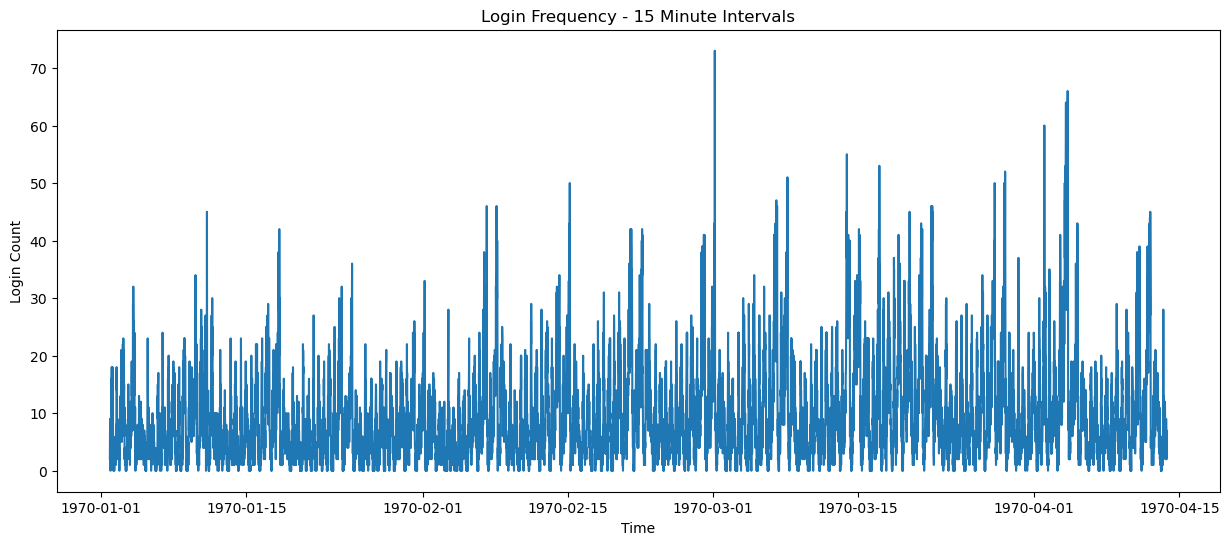

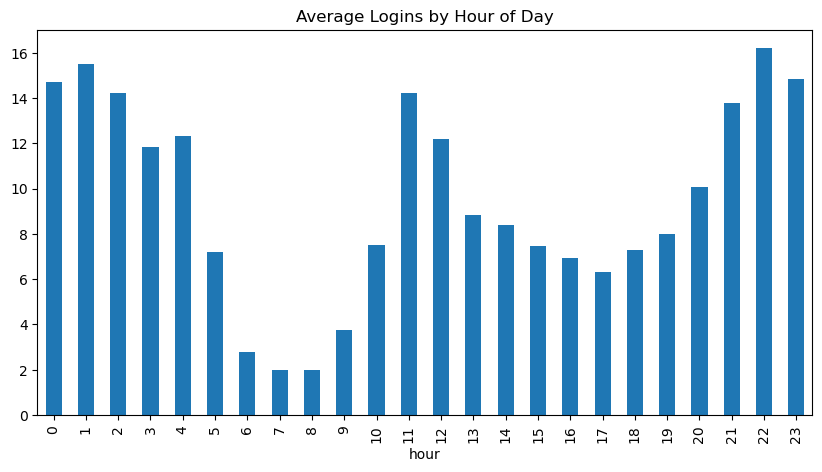

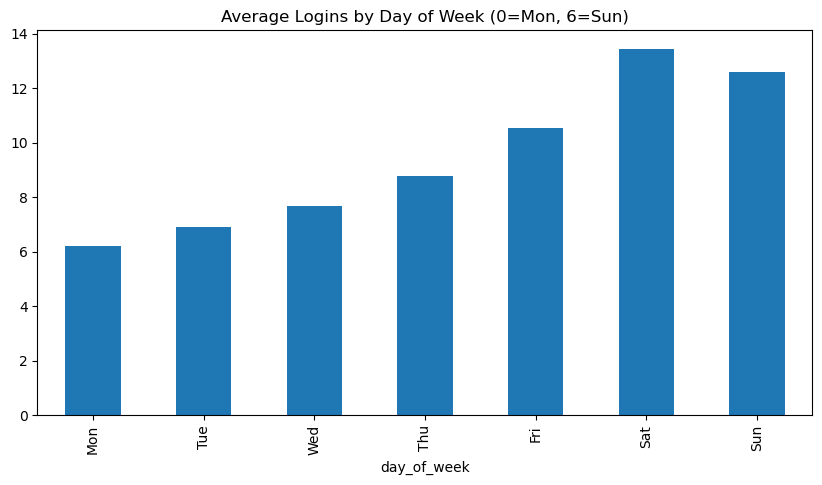

C:\Users\dylan\AppData\Local\Temp\ipykernel_39904\3347840674.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
C:\Users\dylan\AppData\Local\Temp\ipykernel_39904\3347840674.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

Fraction of users retained: 37.61%
Model Accuracy: 0.78

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83      6219
           1       0.74      0.66      0.70      3781

    accuracy                           0.78     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.78      0.78      0.78     10000



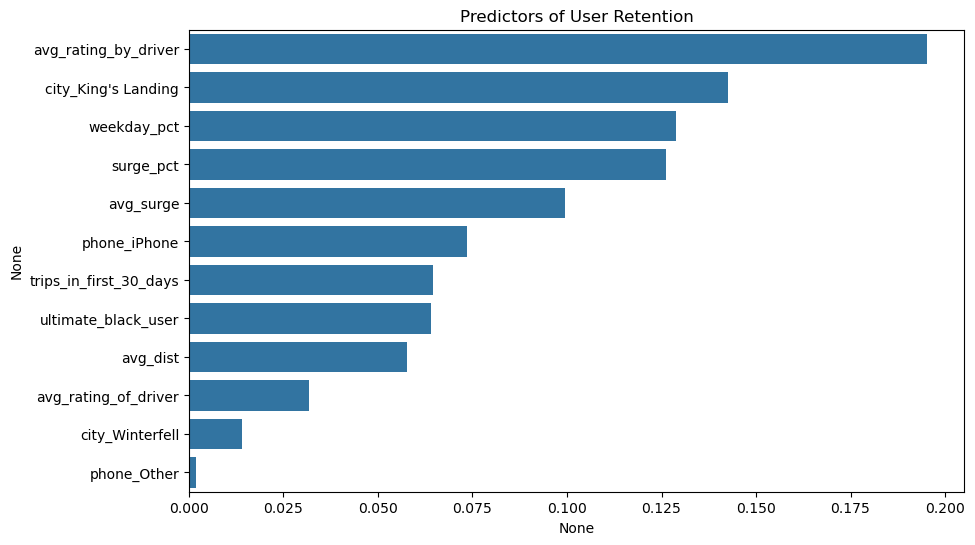

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ==========================================
# PART 1: EXPLORATORY DATA ANALYSIS (LOGINS)
# ==========================================

# 1.1 Load and Resample Data
logins = pd.read_json('logins.json')
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins.set_index('login_time', inplace=True)
logins['count'] = 1

# Aggregate into 15-minute intervals
logins_15 = logins.resample('15T').count()

# 1.2 Visualize Cycles
plt.figure(figsize=(15, 6))
plt.plot(logins_15)
plt.title('Login Frequency - 15 Minute Intervals')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.show()

# Daily and Weekly Trends
logins_15['hour'] = logins_15.index.hour
logins_15['day_of_week'] = logins_15.index.dayofweek

# Daily Cycle
plt.figure(figsize=(10, 5))
logins_15.groupby('hour')['count'].mean().plot(kind='bar')
plt.title('Average Logins by Hour of Day')
plt.show()

# Weekly Cycle
plt.figure(figsize=(10, 5))
logins_15.groupby('day_of_week')['count'].mean().plot(kind='bar')
plt.title('Average Logins by Day of Week (0=Mon, 6=Sun)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# ==========================================
# PART 3: PREDICTIVE MODELING (RETENTION)
# ==========================================

# 3.1 Load and Clean Data
with open('ultimate_data_challenge.json') as f:
    import json
    data = json.load(f)
df = pd.DataFrame(data)

# Convert dates
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

# Handle missing values
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('Other', inplace=True)

# 3.2 Define Retention
# Data pull date is the max last_trip_date in the dataset
pull_date = df['last_trip_date'].max()
cutoff_date = pull_date - pd.Timedelta(days=30)
df['retained'] = (df['last_trip_date'] >= cutoff_date).astype(int)

print(f"Fraction of users retained: {df['retained'].mean():.2%}")

# 3.3 Feature Engineering
df_encoded = pd.get_dummies(df.drop(['signup_date', 'last_trip_date'], axis=1), 
                            columns=['city', 'phone'], drop_first=True)
df_encoded['ultimate_black_user'] = df_encoded['ultimate_black_user'].astype(int)

# 3.4 Modeling (Random Forest)
X = df_encoded.drop('retained', axis=1)
y = df_encoded['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# 3.5 Evaluation
y_pred = rf.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title('Predictors of User Retention')
plt.show()